# FacebookPagePage

In [1]:
import os
import torch
import numpy as np
import pickle
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# %pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# %pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# %pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
# %pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html


import os.path as osp
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch.nn.functional as F


2.1.1


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## Stage 3: Reconstruct the original graph using the subgraphs from GNNExplainer.

### 匯入資料

In [16]:
# 讀入檔案
with open('./dataset/Facebook/dataset_train.pickle', 'rb') as file:
    dataset_train = pickle.load(file)

with open('./dataset/Facebook/dataset_valid.pickle', 'rb') as file:
    dataset_valid = pickle.load(file)

with open('./dataset/Facebook/dataset_test.pickle', 'rb') as file:
    dataset_test = pickle.load(file)

print(len(dataset_train))
print(dataset_train[0])
print(len(dataset_valid))
print(dataset_valid[0])
print(len(dataset_test))
print(dataset_test[0])

100
Data(x=[5769, 128], edge_index=[2, 144755], edge_label=[108137], edge_label_index=[2, 108137], edge_subgraph_index=[2, 36618], train=True)
20
Data(x=[4757, 128], edge_index=[2, 30054], edge_label=[148610], edge_label_index=[2, 148610], edge_subgraph_index=[2, 30054], train=False)
20
Data(x=[5653, 128], edge_index=[2, 29678], edge_label=[251996], edge_label_index=[2, 251996], edge_subgraph_index=[2, 29678], train=False)


In [18]:
def numbers(dataset):    
    ns = []
    es = []
    ls = []
    for i in range(len(dataset)):
        # 點的資訊
        n = dataset[i].x.shape[0]
        # 給的邊資訊
        e = dataset[i].edge_index.shape[1]
        # 預測的數量
        l = dataset[i].edge_label.shape[0]
        ns.append(n)
        es.append(e)
        ls.append(l)

    print("平均節點數量", np.mean(ns))
    print("平均給定邊的數量", np.mean(es))
    print("平均欲預測的邊數量", np.mean(ls))

In [19]:
print(numbers(dataset_train))
print(numbers(dataset_valid))
print(numbers(dataset_test))

平均節點數量 6015.26
平均給定邊的數量 141732.35
平均欲預測的邊數量 98891.52
None
平均節點數量 5806.6
平均給定邊的數量 38905.5
平均欲預測的邊數量 190120.4
None
平均節點數量 5689.55
平均給定邊的數量 38655.35
平均欲預測的邊數量 196999.6
None


In [20]:
from torch_geometric.data import DataLoader

# 創建 DataLoader 
train_loader = DataLoader(dataset_train, batch_size=8, shuffle=True)
val_loader = DataLoader(dataset_valid, batch_size=8)
test_loader = DataLoader(dataset_test, batch_size=8)

/Users/liang/anaconda3/envs/PyG/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


### Start Link prediction with GNN

In [237]:
from torch_geometric.nn import GCNConv,GATConv, GraphSAGE


class MyGNN(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # create you GNN layer here.

        # try to use different GNN backbone layer or stacking multiple layer to boost performance
        self.conv1 = GCNConv(128, 128)
        self.conv2 = GCNConv(128, 64)
        # self.conv1 = GATConv(128, 128)
        # self.conv2 = GATConv(128, 64)
        # self.conv1 = GraphSAGE(128, 128, num_layers=2)
        # self.conv2 = GraphSAGE(128, 64, num_layers=2)
        # self.dropout = torch.nn.Dropout(0.3)


    def forward(self, x, edge_index):
        # Apply the forward pass acorrding to your GNN layers
        # you shoud return the embedding of each node (x has shape [num_nodes, dim])
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # x = F.dropout(x, p=0.3)
        x = self.conv2(x, edge_index)
        return x
        

    def get_prediction(self,node_embedding, edges):
        # In this function, we have the node embedding and edges as input
        # The output is to generate a scalar for each pair of edge
        # To generate such output, we use the inner product of embeddings of two nodes
        # Input shapes:
        #      node_embedding: (|V|, out_channels)
        #      edges: (2, number of edges)
        embedding_first_node = node_embedding[edges[0]]
        embedding_second_node = node_embedding[edges[1]]

        # implement the element-wise product as edge feature for link prediction
        inner_product = torch.sum(embedding_first_node * embedding_second_node, dim=-1)

        return inner_product

In [ ]:
# model = torch.load('./models/2_GCNmodel_1.pt')

In [266]:
# initiate your GNN model and select the criterion for link prediction

model = MyGNN().to(device)
print(model)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()
n_epoch=150
neg = 1 #訓練時生成多少倍的負樣本
threshord = 0.5 # 二元分類的閾值

# 第幾次嘗試
trytry = 2

MyGNN(
  (conv1): GCNConv(128, 128)
  (conv2): GCNConv(128, 64)
)


In [267]:
from torch_geometric.utils import negative_sampling

# Implement the train function
def train(train_loader, model):
    model.train()

    total_loss = 0
    total_samples = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()

        embedding = model(batch.x, batch.edge_index)

        # 生成負樣本
        neg_edge_index = negative_sampling(
                        edge_index= batch.edge_index, num_nodes=batch.x.size(0),
                        num_neg_samples= int(batch.edge_label_index.size(1)*neg), method='sparse') 
        all_edge_index = torch.cat([batch.edge_label_index, neg_edge_index], dim=-1)
        edge_label = torch.cat([batch.edge_label,
                                batch.edge_label.new_zeros(neg_edge_index.size(1))], dim=0)
        
        # make prediction
        pred = model.get_prediction(embedding, all_edge_index).view(-1)

        # optimization
        loss = criterion(pred, edge_label.float())
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.size(0)
        total_samples += pred.size(0)

    return total_loss / total_samples
    

In [268]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score
import numpy as np

@torch.no_grad()
def test(test_loader, model):
    model.eval()
    
    all_preds = []
    all_labels = []
    
    for batch in test_loader:
        embedding = model(batch.x, batch.edge_index)
        out = model.get_prediction(embedding, batch.edge_label_index).view(-1).sigmoid()
        
        all_preds.append(out.cpu().numpy())
        all_labels.append(batch.edge_label.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    acc = accuracy_score(all_labels, all_preds > threshord)
    precision = precision_score(all_labels, all_preds > threshord)
    recall = recall_score(all_labels, all_preds > threshord)
    f1 = f1_score(all_labels, all_preds > threshord)
    roc_auc = roc_auc_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds > threshord)
    
    return acc, precision, recall, f1, roc_auc, cm


In [269]:
loss_record = []
val_acc_record = []
test_acc_record = []
val_pr_record = []
test_pr_record = []
val_re_record = []
test_re_record = []
val_f1_record = []
test_f1_record = []
val_auc_record = []
test_auc_record = []
val_cm_record = []
test_cm_record = []

In [279]:
for epoch in range(n_epoch):
    loss = train(train_loader, model)
    val_acc, val_precision, val_recall, val_f1, val_auc, val_cm = test(val_loader, model)
    test_acc, test_precision, test_recall, test_f1, test_auc, test_cm = test(test_loader, model)
    
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Acc: {test_acc:.4f}, '
          f'AUC: {test_auc:.4f}, Pr: {test_precision:.4f}, Re: {test_recall:.4f}, F1: {test_f1:.4f}')

    loss_record.append(loss)    
    val_acc_record.append(val_acc)
    test_acc_record.append(test_acc)
    val_pr_record.append(val_precision)
    val_re_record.append(val_recall)
    val_f1_record.append(val_f1)
    test_pr_record.append(test_precision)
    test_re_record.append(test_recall)
    test_f1_record.append(test_f1)
    val_auc_record.append(val_auc)
    test_auc_record.append(test_auc)
    val_cm_record.append(val_cm)
    test_cm_record.append(test_cm)

Epoch: 000, Loss: 0.5444, Acc: 0.7555, AUC: 0.8835, Pr: 0.6886, Re: 0.9330, F1: 0.7924
Epoch: 001, Loss: 0.5407, Acc: 0.7553, AUC: 0.8863, Pr: 0.6873, Re: 0.9369, F1: 0.7929
Epoch: 002, Loss: 0.5420, Acc: 0.7503, AUC: 0.8850, Pr: 0.6823, Re: 0.9368, F1: 0.7896
Epoch: 003, Loss: 0.5416, Acc: 0.7583, AUC: 0.8829, Pr: 0.6926, Re: 0.9290, F1: 0.7935
Epoch: 004, Loss: 0.5431, Acc: 0.7530, AUC: 0.8803, Pr: 0.6879, Re: 0.9264, F1: 0.7895
Epoch: 005, Loss: 0.5398, Acc: 0.7535, AUC: 0.8845, Pr: 0.6868, Re: 0.9321, F1: 0.7909
Epoch: 006, Loss: 0.5401, Acc: 0.7548, AUC: 0.8813, Pr: 0.6888, Re: 0.9298, F1: 0.7913
Epoch: 007, Loss: 0.5416, Acc: 0.7525, AUC: 0.8800, Pr: 0.6867, Re: 0.9288, F1: 0.7896
Epoch: 008, Loss: 0.5447, Acc: 0.7463, AUC: 0.8796, Pr: 0.6797, Re: 0.9315, F1: 0.7859
Epoch: 009, Loss: 0.5425, Acc: 0.7488, AUC: 0.8822, Pr: 0.6822, Re: 0.9314, F1: 0.7876
Epoch: 010, Loss: 0.5429, Acc: 0.7503, AUC: 0.8804, Pr: 0.6831, Re: 0.9337, F1: 0.7890
Epoch: 011, Loss: 0.5415, Acc: 0.7549, AUC:

In [286]:
# 將每個 epoch 的結果存成 pickle
evaluation_record = {
    "loss": loss_record,
    "val_acc": val_acc_record,
    "test_acc": test_acc_record,
    "val_pr": val_pr_record,
    "test_pr": test_pr_record,
    "val_re": val_re_record,
    "test_re": test_re_record,
    "val_f1": val_f1_record,
    "test_f1": test_f1_record,
    "val_auc": val_auc_record,
    "test_auc": test_auc_record,
    "val_cm": val_cm_record,
    "test_cm": test_cm_record,
}

with open(f'./plot/Facebook/2_GCN_Evaluation_{trytry}.pickle', 'wb') as file:
    pickle.dump(evaluation_record, file)
    
print(f"已將 evaluation_record 存至 ./plot/Facebook/2_GCN_Evaluation_{trytry}.pickle")

已將 evaluation_record 存至 ./plot/Facebook/2_GCN_Evaluation_2.pickle


In [287]:
# 儲存模型
torch.save(model, f'./models/Facebook/2_GCN_model_{trytry}.pt')

In [288]:
# 最後結果的confusion matrix
print(val_cm_record[-1])
print(test_cm_record[-1])

[[1102974  798230]
 [ 150758 1750446]]
[[1156170  813826]
 [ 154506 1815490]]


已儲存圖片至 ./plot/Facebook/2_GCN_lossAUCAcc_2.png


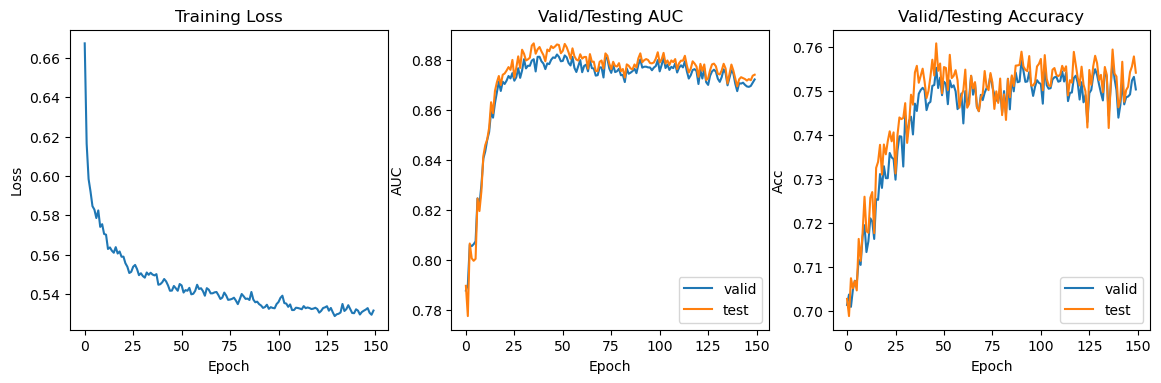

In [290]:
plt.figure(figsize=(12, 4))
plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.15, wspace=0.2)

# loss
plt.subplot(1,3,1)
plt.plot(range(n_epoch), loss_record) # n_epoch
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Training Loss")

# auc
plt.subplot(1,3,2)
plt.plot(range(n_epoch), val_auc_record, label='valid')
plt.plot(range(n_epoch), test_auc_record, label='test')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.title(f"Valid/Testing AUC")

# acc
plt.subplot(1,3,3)
plt.plot(range(n_epoch), val_acc_record, label='valid')
plt.plot(range(n_epoch), test_acc_record, label='test')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Acc")
plt.title(f"Valid/Testing Accuracy")


plt.savefig(f'./plot/Facebook/2_GCN_lossAUCAcc_{trytry}.png', dpi=300)
print(f"已儲存圖片至 ./plot/Facebook/2_GCN_lossAUCAcc_{trytry}.png")

plt.show()


已儲存圖片至 ./Facebook/plot/2_GCN_PrReF1_2.png


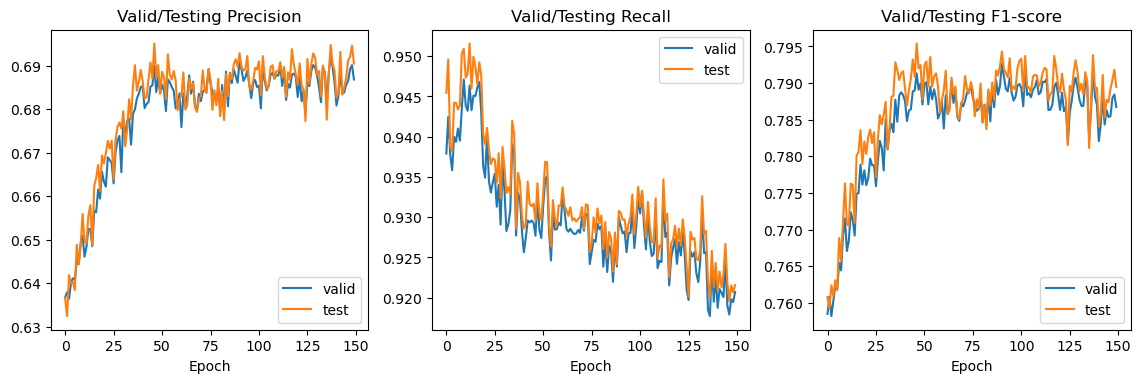

In [291]:
plt.figure(figsize=(12, 4))
plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.15, wspace=0.2)

# precision 
plt.subplot(1, 3, 1)
plt.plot(range(n_epoch), val_pr_record, label='valid')
plt.plot(range(n_epoch), test_pr_record, label='test')
plt.legend()
plt.xlabel("Epoch")
plt.title(f"Valid/Testing Precision")

# recall
plt.subplot(1, 3, 2)
plt.plot(range(n_epoch), val_re_record, label='valid')
plt.plot(range(n_epoch), test_re_record, label='test')
plt.legend()
plt.xlabel("Epoch")
plt.title(f"Valid/Testing Recall")

# f1-score
plt.subplot(1 ,3, 3)
plt.plot(range(n_epoch), val_f1_record, label='valid')
plt.plot(range(n_epoch), test_f1_record, label='test')
plt.legend()
plt.xlabel("Epoch")
plt.title(f"Valid/Testing F1-score")

plt.savefig(f'./plot/Facebook/2_GCN_PrReF1_{trytry}.png', dpi=300)
print(f"已儲存圖片至 ./Facebook/plot/2_GCN_PrReF1_{trytry}.png")

plt.show()